# Support Vector Machines

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score,f1_score



#Set figure size
sns.set(rc={'figure.figsize':(5,5)})

#Load data
df = pd.read_csv(os.path.join('data','data_filtered.csv'))
df2  = pd.read_csv(os.path.join('data','data_all.csv'))

#Enable CUDA
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

df

,sd,Q25,IQR,sp.ent,sfm,meanfun,mindom,dfrange,label
0,0.241585,0.455971,-0.601712,0.796058,0.925288,1.302489,-0.708404,-0.415794,1
1,-0.114476,-0.105393,0.401743,0.461699,-0.229014,-0.259737,-0.461523,0.412186,0
2,-1.284107,1.726540,-1.169425,-1.599113,-1.269425,1.315527,-0.461523,1.777355,1
3,1.089943,-0.391539,0.786946,0.578250,0.982092,-0.698228,-0.708404,-0.679948,0
4,0.231523,0.681061,-0.527833,0.508050,0.516462,1.167348,-0.708404,-1.343664,1
...,...,...,...,...,...,...,...,...,...
3163,1.087355,-0.480803,0.982768,1.385949,1.667369,-0.969765,-0.338082,-1.208257,0
3164,-1.471392,0.863030,-1.176833,-0.555301,-1.128432,0.530223,1.143207,-1.214917,1
3165,0.644400,-0.395149,0.953317,0.626947,0.305185,-0.983770,-0.708404,-0.688828,0
3166,1.557415,-0.558784,0.970942,1.076622,1.232644,-0.441604,-0.708404,-0.005133,0


In [2]:
feature_size = len(df.drop(['label'],axis=1).columns)
print(f'Number of Features: {feature_size}')

train_x, test_x, train_y, test_y = train_test_split(
    df.drop(['label'], axis=1), df['label'], test_size=0.2, random_state=42)


Number of Features: 8


Making use of <b>sklearn</b>'s SVM function, we have a number of parameters to tweak. We can try different parameters and see which gives the best accuracy.

In [3]:
def run(C: float = 1.0,        # Regularisation Parameter
        kernel: str = 'rbf',   # [linear,poly,rbf,sigmoid,precomputed]
        degree: int = 3,       # Degree of the polynomial function if kernel=='poly'
        shrinking: bool = True,# Whether to use the shrinking heuristic
        show=True):            # Print metrics to standard output)
    
    svm_clf = svm.SVC(C=C,
                      kernel=kernel,
                      degree=degree,
                      shrinking=shrinking).fit(train_x, train_y)
    prediction = svm_clf.predict(test_x)
    
    # Generate Accuracy, Precision, Recall, F1 Score
    accuracy = accuracy_score(prediction, test_y)
    precision = precision_score(prediction, test_y)
    recall = recall_score(prediction, test_y)
    f1 = f1_score(prediction, test_y)
    
    if not show:
        return (accuracy,precision,recall,f1)
    
    #Generate confusion matrix
    cm = confusion_matrix(test_y, prediction)
    count      = ["{0:0.0f}".format(v) for v in cm.flatten()]
    percentage = ["{0:.2%}".format(v) for v in cm.flatten()/np.sum(cm)]
    labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in
              zip(count,percentage)]).reshape(2,2)
    sns.heatmap(cm,fmt='',annot=labels)
    
    # Print to standard output
    print('Accuracy:\t%.3f' % accuracy)
    print('Precision:\t%.3f' % precision)
    print('Recall:  \t%.3f' % recall)
    print('F1 Score:\t%.3f' % f1)
    
    return [accuracy,precision,recall,f1]

# Evaluation

## Trying different kernels

In [4]:
data = []

Accuracy:	0.978
Precision:	0.971
Recall:  	0.984
F1 Score:	0.977


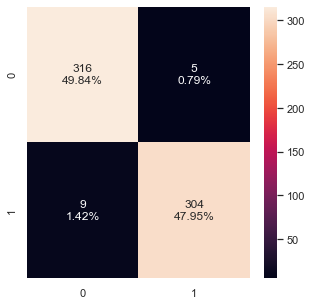

In [5]:
data.append(['Linear']+run(kernel='linear'))

Accuracy:	0.964
Precision:	0.939
Recall:  	0.987
F1 Score:	0.962


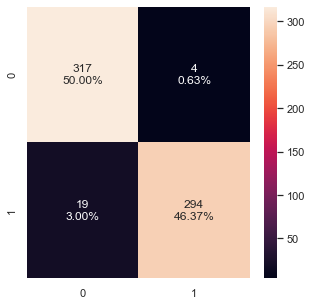

In [6]:
data.append(['Poly']+run(kernel='poly'))

Accuracy:	0.979
Precision:	0.981
Recall:  	0.978
F1 Score:	0.979


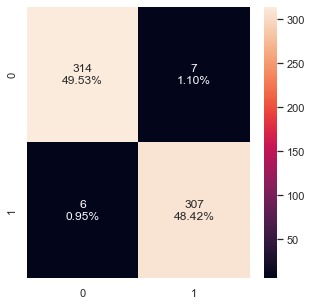

In [7]:
data.append(['RBF']+run(kernel='rbf'))

Accuracy:	0.826
Precision:	0.843
Recall:  	0.812
F1 Score:	0.828


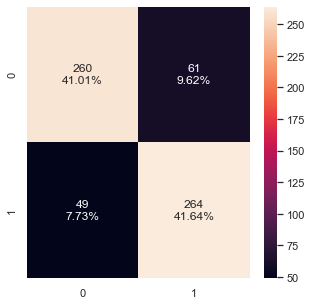

In [8]:
data.append(['Sigmoid']+run(kernel='sigmoid'))

In [9]:
metrics_df = pd.DataFrame(data,columns=['Kernel','Accuracy','Prediction','Recall','F1 Score'])

			Performance of SVM with different kernels


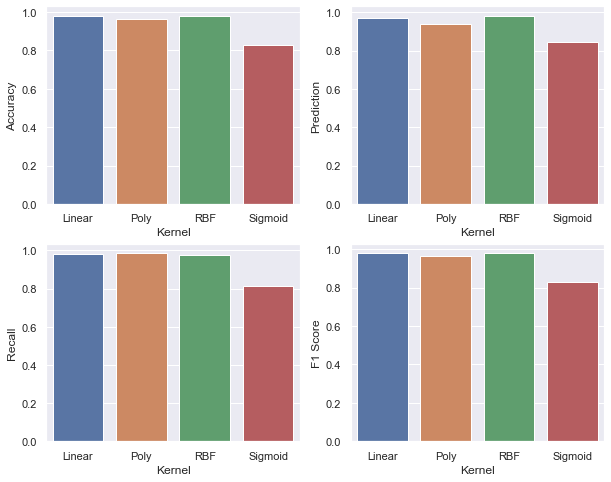

In [10]:
sns.set(rc={'figure.figsize':(10,8)})
fig,ax = plt.subplots(2,2)

sns.barplot(data=metrics_df, x='Kernel',y='Accuracy',  ax=ax[0][0])
sns.barplot(data=metrics_df, x='Kernel',y='Prediction',ax=ax[0][1])
sns.barplot(data=metrics_df, x='Kernel',y='Recall',    ax=ax[1][0])
sns.barplot(data=metrics_df, x='Kernel',y='F1 Score',  ax=ax[1][1])

ax[0][0].set_ylabel("Accuracy")
ax[0][1].set_ylabel("Prediction")
ax[1][0].set_ylabel("Recall")
ax[1][1].set_ylabel("F1 Score")
print('\t\t\tPerformance of SVM with different kernels')

## Differnet polynomial degrees for <code>kernel=poly</code>

In [11]:
data = []
for degree in range(1,21):
    
    #Evaluate SVM with current degree
    a,p,r,f = run(kernel='poly', degree=degree,show=False)
    
    #Tally metrics
    data.append([degree,a,p,r,f])

metrics_df = pd.DataFrame(data,columns=['Degree','Accuracy','Prediction','Recall','F1 Score'])

Text(0.5, 1.0, 'SVM with $poly$ kernel with different values for $degree$')

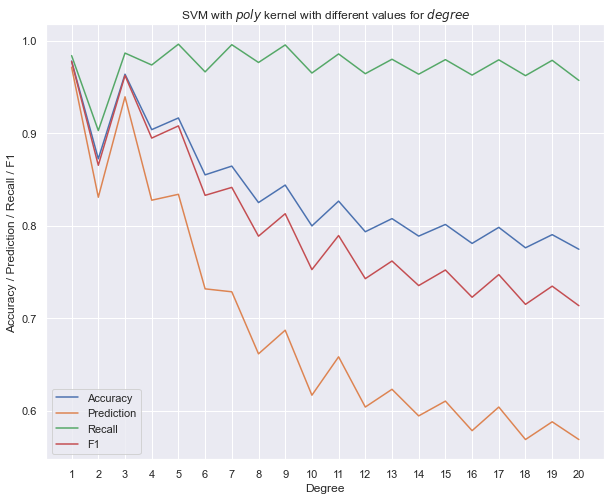

In [12]:
sns.set(rc={'figure.figsize':(10,8)})
fig,ax = plt.subplots(1,1)

sns.lineplot(data=metrics_df, x='Degree',y='Accuracy',  ax=ax)
sns.lineplot(data=metrics_df, x='Degree',y='Prediction',ax=ax)
sns.lineplot(data=metrics_df, x='Degree',y='Recall',    ax=ax)
sns.lineplot(data=metrics_df, x='Degree',y='F1 Score',  ax=ax)

ax.set_ylabel("Accuracy / Prediction / Recall / F1")
ax.legend(["Accuracy","Prediction","Recall","F1"])
ax.set_xticks(range(1,21,1))
ax.set_title('SVM with $poly$ kernel with different values for $degree$')

## Visualising the effect of the <code>C</code> parameter

We will visualise how the C parameter affects the accuracy, precision, recall, and F1 score for an SVC with <code>kernel='rbf'</code>

In [13]:
data = []
for c in np.arange(0.1,21,0.05):
    
    #Evaluate SVM with current C parameter
    a,p,r,f = run(C=c, show=False)
    
    #Tally metrics
    data.append([c,a,p,r,f])

metrics_df = pd.DataFrame(data,columns=['C','Accuracy','Prediction','Recall','F1 Score'])

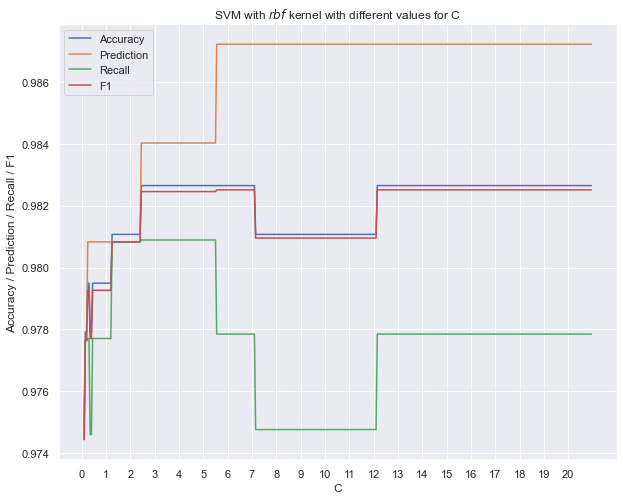

In [14]:
sns.set(rc={'figure.figsize':(10,8)})
fig,ax = plt.subplots(1,1)

sns.lineplot(data=metrics_df, x='C',y='Accuracy', ax=ax)
sns.lineplot(data=metrics_df, x='C',y='Prediction', ax=ax)
sns.lineplot(data=metrics_df, x='C',y='Recall', ax=ax)
sns.lineplot(data=metrics_df, x='C',y='F1 Score', ax=ax)

ax.set_ylabel("Accuracy / Prediction / Recall / F1")
ax.legend(["Accuracy","Prediction","Recall","F1"])
ax.set_title('SVM with $rbf$ kernel with different values for C')
ax.set_xticks(range(0,21,1))
plt.show()

# Conclusions

• The best kernel was <code>rbf</code> while the worst was <code>sigmoid</code>.

• The best polynomial degree when using <code>kernel=poly</code> was 3.

• The best value for <code>C</code> when using <code>kernel=rbf</code> was between 3 and 5.

The best SVM in terms of performance is:


Accuracy:	0.983
Precision:	0.984
Recall:  	0.981
F1 Score:	0.982


[0.9826498422712934,
 0.9840255591054313,
 0.9808917197452229,
 0.9824561403508771]

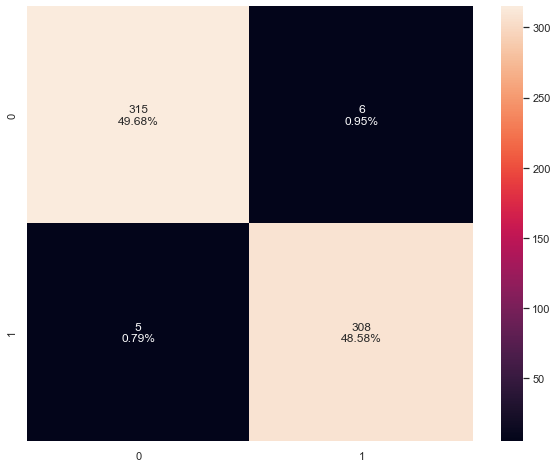

In [15]:
run(C=4,kernel='rbf')